In [10]:
# Cell 1: Optimized Imports and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Configuration ---
PROCESSED_FILE = '../../data/processed/listings_cleaned_with_target.csv'
RAW_SF = '../../data/raw/san francisco.csv'
RAW_SD = '../../data/raw/san diego.csv'
FIGURES_PATH = '../../outputs/figures/'

os.makedirs(FIGURES_PATH, exist_ok=True)
sns.set_style("whitegrid")

print("1. Loading Processed Data...")
df = pd.read_csv(PROCESSED_FILE)

# --- FAST FIX: Recover missing columns using 'usecols' ---
# Sadece gerekli 3 kolonu okuyarak yükleme süresini %90 azaltıyoruz
print("2. Recovering missing categories (Fast Mode)...")
cols_needed = ['id', 'room_type', 'neighbourhood_cleansed']

# Read only specific columns
raw_sf = pd.read_csv(RAW_SF, usecols=cols_needed)
raw_sd = pd.read_csv(RAW_SD, usecols=cols_needed)
df_raw = pd.concat([raw_sf, raw_sd], ignore_index=True)

# Merge back to main dataframe
df = df.merge(df_raw, on='id', how='left')

print(f"✅ Data Ready. Shape: {df.shape}")
print(df[['price', 'value_category', 'room_type']].head())

1. Loading Processed Data...
2. Recovering missing categories (Fast Mode)...
✅ Data Ready. Shape: (19912, 73)
   price   value_category        room_type
0  157.0       Fair_Value  Entire home/apt
1  250.0       Poor_Value  Entire home/apt
2   67.0  Excellent_Value     Private room
3   56.0  Excellent_Value     Private room
4  527.0       Poor_Value  Entire home/apt


1️⃣ Generating Price vs. Rating Scatter Plot...
✓ Saved: ../../outputs/figures/bivariate_price_vs_rating.png


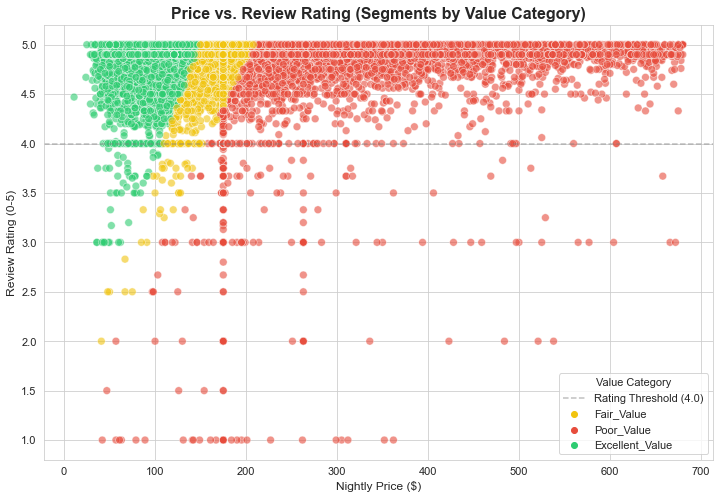

In [11]:
# Cell 2: Price vs. Review Rating Scatter Plot
print("1️⃣ Generating Price vs. Rating Scatter Plot...")

plt.figure(figsize=(12, 8))

# Filter extreme outliers for a clearer chart (e.g., price < $800)
# This is only for visualization purposes
subset = df[df['price'] < 800]

# Scatter plot with semantic coloring (Value Category)
sns.scatterplot(
    data=subset, 
    x='price', 
    y='review_scores_rating', 
    hue='value_category', 
    palette={'Poor_Value': '#e74c3c', 'Fair_Value': '#f1c40f', 'Excellent_Value': '#2ecc71'},
    alpha=0.6,
    s=60
)

plt.title('Price vs. Review Rating (Segments by Value Category)', fontsize=16, fontweight='bold')
plt.xlabel('Nightly Price ($)', fontsize=12)
plt.ylabel('Review Rating (0-5)', fontsize=12)
plt.axhline(4.0, color='gray', linestyle='--', alpha=0.5, label='Rating Threshold (4.0)')
plt.legend(title='Value Category', loc='lower right')

# Save
save_path = os.path.join(FIGURES_PATH, 'bivariate_price_vs_rating.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {save_path}")
plt.show()

2️⃣ Generating Room Type Analysis...
✓ Saved: ../../outputs/figures/bivariate_roomtype_vs_target.png


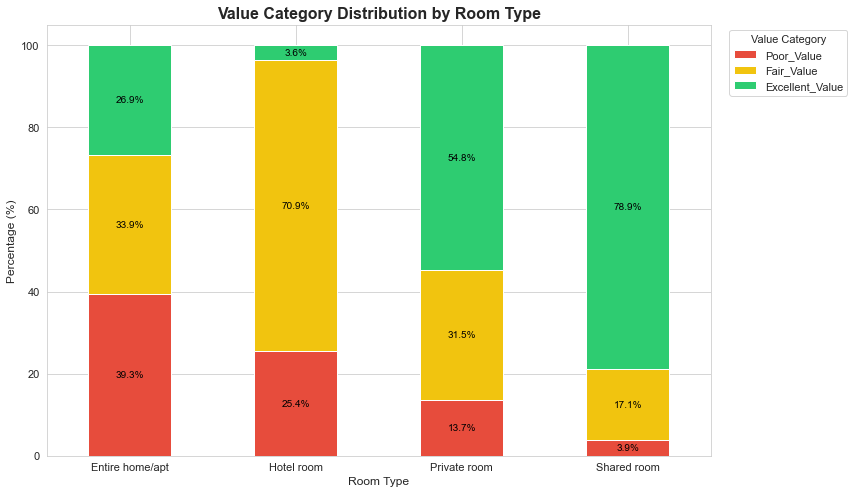

In [12]:
# Cell 3: Value Category Distribution by Room Type
print("2️⃣ Generating Room Type Analysis...")

# Create a contingency table (Cross-tabulation)
# We normalize by index to get percentages within each room type
ct = pd.crosstab(df['room_type'], df['value_category'], normalize='index') * 100

# Reorder columns for logical flow
ct = ct[['Poor_Value', 'Fair_Value', 'Excellent_Value']]

# Plot Stacked Bar Chart
ax = ct.plot(kind='bar', stacked=True, color=['#e74c3c', '#f1c40f', '#2ecc71'], figsize=(12, 7))

plt.title('Value Category Distribution by Room Type', fontsize=16, fontweight='bold')
plt.xlabel('Room Type', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.legend(title='Value Category', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=0)

# Add percentage labels on bars
for c in ax.containers:
    ax.bar_label(c, fmt='%.1f%%', label_type='center', color='black', fontsize=10)

plt.tight_layout()

# Save
save_path = os.path.join(FIGURES_PATH, 'bivariate_roomtype_vs_target.png')
plt.savefig(save_path, dpi=300)
print(f"✓ Saved: {save_path}")
plt.show()

3️⃣ Generating Neighbourhood Price Analysis...
✓ Saved: ../../outputs/figures/bivariate_neighbourhood_price.png


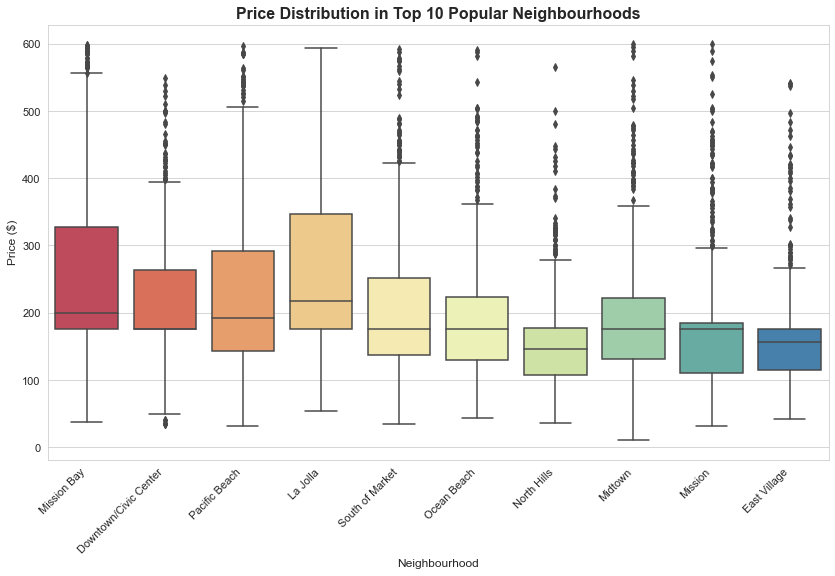

In [13]:
# Cell 4: Price Distribution by Top 10 Neighbourhoods
print("3️⃣ Generating Neighbourhood Price Analysis...")

# Identify Top 10 Neighbourhoods by number of listings
top_10_neighbourhoods = df['neighbourhood_cleansed'].value_counts().head(10).index
subset_nb = df[df['neighbourhood_cleansed'].isin(top_10_neighbourhoods)]

# Filter price outliers for visualization clarity
subset_nb = subset_nb[subset_nb['price'] < 600]

plt.figure(figsize=(14, 8))
sns.boxplot(
    data=subset_nb,
    x='neighbourhood_cleansed',
    y='price',
    palette='Spectral',
    order=top_10_neighbourhoods # Maintain order by popularity
)

plt.title('Price Distribution in Top 10 Popular Neighbourhoods', fontsize=16, fontweight='bold')
plt.xlabel('Neighbourhood', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Save
save_path = os.path.join(FIGURES_PATH, 'bivariate_neighbourhood_price.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {save_path}")
plt.show()

4️⃣ Generating Correlation Matrix...
✓ Saved: ../../outputs/figures/bivariate_correlation_heatmap.png


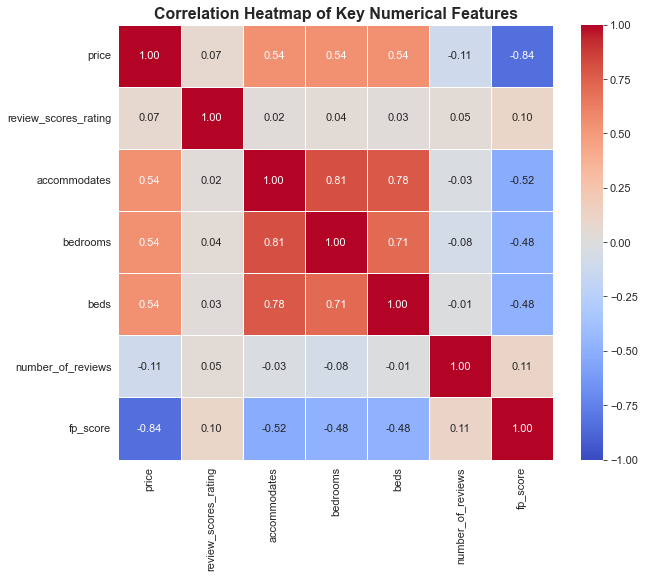

In [14]:
# Cell 5: Correlation Heatmap
print("4️⃣ Generating Correlation Matrix...")

# Select numerical columns of interest
numeric_cols = ['price', 'review_scores_rating', 'accommodates', 'bedrooms', 
                'beds', 'number_of_reviews', 'fp_score']

# Calculate correlation matrix
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, 
    annot=True,       # Show numbers
    fmt='.2f',        # 2 decimal places
    cmap='coolwarm',  # Red-Blue colormap
    vmin=-1, vmax=1,  # Scale from -1 to 1
    linewidths=0.5,
    square=True
)

plt.title('Correlation Heatmap of Key Numerical Features', fontsize=16, fontweight='bold')

# Save
save_path = os.path.join(FIGURES_PATH, 'bivariate_correlation_heatmap.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {save_path}")
plt.show()

5️⃣ Generating Capacity vs. Price Analysis...
✓ Saved: ../../outputs/figures/bivariate_accommodates_price.png


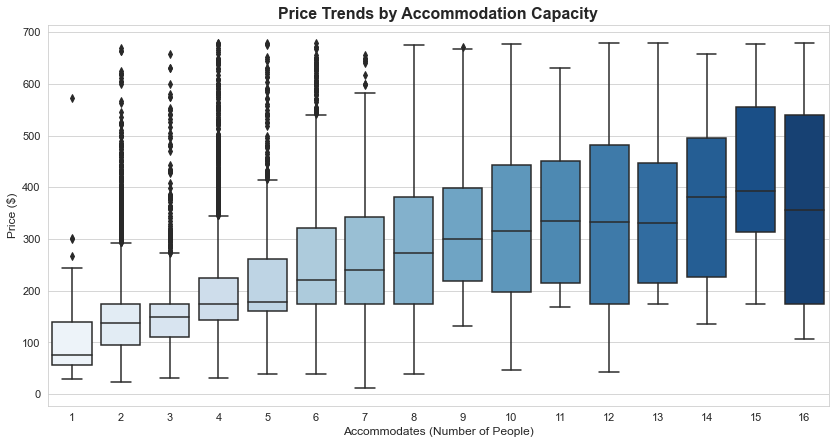


✅ Task 1.15 (Bivariate Analysis) Completed Successfully.


In [15]:
# Cell 6: Capacity (Accommodates) vs. Price Boxplot
print("5️⃣ Generating Capacity vs. Price Analysis...")

plt.figure(figsize=(14, 7))

# Filter extreme prices
subset_acc = df[df['price'] < 1000]

sns.boxplot(
    data=subset_acc, 
    x='accommodates', 
    y='price', 
    palette='Blues'
)

plt.title('Price Trends by Accommodation Capacity', fontsize=16, fontweight='bold')
plt.xlabel('Accommodates (Number of People)', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)

# Save
save_path = os.path.join(FIGURES_PATH, 'bivariate_accommodates_price.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {save_path}")
plt.show()

print("\n✅ Task 1.15 (Bivariate Analysis) Completed Successfully.")